**News Classification by LSTM**

In this notebook, we will try to classify news merely from the language associated with it. We just use its headline and short description to classify the news's category. One thing we intentionally avoid is the author's name due to tendency of certain author to write articles on particular topics.

In general this notebook is comprised of some sections which are:
1. Preparing data
2. Building the model
3. Training the model
4. User input

We use some components here to name a few:
* Torchtext library
* Pre-trained word embedding
* LSTM network architecture
* Bidirectional LSTM
* Multi-layered LSTM
* Regularization
* Adam optimizer
* Cross-entropy loss function for classification problem

**Preparing Data**

We use Torchtext library to pre-process our data. Torchtext simplifies text data pre-processing that includes reading data, tokenizing, converting into tensors, and building vocabulary to be easier.

In [48]:
import torch
from torchtext.legacy import data

So first we specify what our data comprises of. We decide that our data comprises of TEXT which are the news' headlines and short descriptions, as well as LABEL which is the news' category. Here we tokenize the text using [spacy](https://spacy.io/?source=post_page---------------------------) tokenizer and to make all the words use lower case. While we keep the entire LABEL as it is.

In [49]:
TEXT = data.Field(tokenize = 'spacy', lower = True)
LABEL = data.LabelField()

Let's use TabularDataset for json type file here. We extract the entirety of our data into something like dictionary with three keys, 'headline', 'desc', and 'category' that corresponds to each news' headline, short description, and category.

In [50]:
news = data.TabularDataset(
    path='input/News_Category_Dataset_v2.json', format='json',
    fields={'headline': ('headline', TEXT),
            'short_description' : ('desc', TEXT),
             'category': ('category', LABEL)})

Further split our dataset into training set trn, validation set vld, and test set tst using seed for reproducible result.

In [51]:
import random
SEED = 1234

trn, vld, tst = news.split(split_ratio=[0.7, 0.2, 0.1], random_state = random.seed(SEED))

We will check an example of our data. It should comprises parsed headline, description, and the associated category.

In [52]:
vars(trn[0])

{'headline': ["'", 'train', 'hard', ',', 'land', 'soft', "'"],
 'desc': ['runners',
  'will',
  'appreciate',
  'that',
  'the',
  'sproing',
  'trainer',
  'was',
  'designed',
  'with',
  'them',
  'in',
  'mind',
  'as',
  'a',
  'way',
  'to',
  'build',
  'endurance',
  'and',
  'strength',
  'without',
  'the',
  'pain',
  'that',
  'can',
  'come',
  'with',
  'pounding',
  'the',
  'pavement',
  '.'],
 'category': 'HEALTHY LIVING'}

We build our vocabulary from our datasets and convert it into vectors from glove. From there we check how many vocabularies we have from our text and how many categories we have.

In [53]:
TEXT.build_vocab(trn, 
                 vectors = "fasttext.simple.300d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(trn)

In [54]:
print(len(TEXT.vocab))
print(len(LABEL.vocab))

78590
41


In [55]:
print(LABEL.vocab.stoi)

defaultdict(None, {'POLITICS': 0, 'WELLNESS': 1, 'ENTERTAINMENT': 2, 'TRAVEL': 3, 'STYLE & BEAUTY': 4, 'PARENTING': 5, 'HEALTHY LIVING': 6, 'QUEER VOICES': 7, 'FOOD & DRINK': 8, 'BUSINESS': 9, 'COMEDY': 10, 'SPORTS': 11, 'BLACK VOICES': 12, 'HOME & LIVING': 13, 'PARENTS': 14, 'THE WORLDPOST': 15, 'WEDDINGS': 16, 'DIVORCE': 17, 'WOMEN': 18, 'IMPACT': 19, 'CRIME': 20, 'MEDIA': 21, 'WEIRD NEWS': 22, 'GREEN': 23, 'WORLDPOST': 24, 'RELIGION': 25, 'STYLE': 26, 'SCIENCE': 27, 'TASTE': 28, 'WORLD NEWS': 29, 'TECH': 30, 'MONEY': 31, 'ARTS': 32, 'FIFTY': 33, 'GOOD NEWS': 34, 'ARTS & CULTURE': 35, 'ENVIRONMENT': 36, 'COLLEGE': 37, 'LATINO VOICES': 38, 'CULTURE & ARTS': 39, 'EDUCATION': 40})


Here, let's wrap out data to get the relevant iterator for our training, validation, as well as test sets.

In [56]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (trn, vld, tst), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key= lambda x: len(x.headline), 
    sort_within_batch= False
    )

**Building the Model**

In this section, we define our model. Since we are trying to classify the news based on its headline and short description that are in the form of sentences or paragraphs, we are going to use sequential model that is LSTM (Long Short Term Memory). More specifically, we use bidirectional and two-layered LSTM layer hopefully to get better accuracy for our prediction. We also implement regularization by using dropout during our forward pass. In this model, we specifically split the processing for the headline and short description and concatenate them before final processing to get the prediction of our news' category. The detail can be seen in the diagram below:

![](https://i.imgur.com/6nXjqx8.png)

In [ ]:
from torchtext.vocab import FastText
embedding = FastText('simple')


In [57]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        
        super().__init__()
                
        self.embedding = embedding
        
        self.lstm_head = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout).to(device)

        self.lstm_desc = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout).to(device)
        
        self.fc_head = nn.Linear(hidden_dim * 2, 100).to(device)
        
        self.fc_desc = nn.Linear(hidden_dim * 2, 100).to(device)
        
        self.fc_total = nn.Linear(200, output_dim).to(device)
        
        self.dropout = nn.Dropout(dropout).to(device)
                
    def forward(self, headline, description):
        # features = self.embedding[x].reshape(x.size()[0], -1)

        embedded_head = self.dropout(self.embedding[headline].reshape(headline.size()[0], -1)
        
        embedded_desc = self.dropout(self.embedding[description].reshape(description.size()[0], -1)
                                    
        output_head, (hidden_head, cell_head) = self.lstm_head(embedded_head)
        
        output_desc, (hidden_desc, cell_desc) = self.lstm_desc(embedded_desc)
        
        hidden_head = self.dropout(torch.cat((hidden_head[-2, :, :], hidden_head[-1, :, :]), dim = 1))
        
        hidden_desc = self.dropout(torch.cat((hidden_desc[-2, :, :], hidden_desc[-1, :, :]), dim = 1))
        
        full_head = self.fc_head(hidden_head)
        
        full_desc = self.fc_desc(hidden_desc)
        
        hidden_total = torch.cat((full_head, full_desc), 1)
        
        return self.fc_total(hidden_total)

Now we create our model and check how many parameters we are training.

In [58]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.2

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

In [59]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,590,129 trainable parameters


Next, replace the initial weights of the embedding layers with the pre-trained embeddings.

In [60]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([78590, 100])


In [61]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 2.2374, -0.1925,  0.0918,  ..., -0.6086, -0.6502,  1.6856],
        [-0.0739,  0.7473,  1.1731,  ...,  0.2251, -0.5670,  0.8037],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0463,  2.1044, -1.5912,  ..., -0.0164,  0.3273,  0.2305],
        [ 0.2965, -0.6914,  0.9111,  ..., -3.6186, -0.2496, -0.7004],
        [-1.9234,  1.2922, -0.5095,  ..., -0.4034,  0.9506,  0.4723]],
       device='cuda:0')

**Training the Model**

We choose Adam algorithm as our optimizer, as well as cross entropy loss for our loss function since we are doing classification problem with multiple categories. We also define the function to calculate accuracy of our prediction.

In [62]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [63]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [64]:
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim = 1, keepdim = True).to(device)
    correct = max_preds.squeeze(1).eq(y).to(device)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)

Here we define the training and evaluate part of our model.

In [65]:
from torchmetrics.functional import f1, precision
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        predictions = model(batch.headline, batch.desc).squeeze(1)

        loss = criterion(predictions, batch.category)

        acc = categorical_accuracy(predictions, batch.category)
        my_f1 = f1(predictions, batch.category, num_classes=41)
        my_prec = precision(predictions, batch.category, average='micro')
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), my_f1, my_prec

In [66]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            
            predictions = model(batch.headline, batch.desc).squeeze(1)
            
            loss = criterion(predictions, batch.category)
            
            acc = categorical_accuracy(predictions, batch.category)
            my_f1 = f1(predictions, batch.category, num_classes=41)
            my_prec = precision(predictions, batch.category, average='micro')
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), my_f1, my_prec

In [67]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


Now we are ready to train our model. We will train it for five epochs.

In [68]:
N_EPOCHS = 5

best_valid_loss = float('inf')
trainLoss= []
trainAcc = []
valLoss= []
valAcc = []
trainF1 = []
valF1 = []
trainPrec = []
valPrec = []
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc, train_f1, train_prec = train(model, train_iterator, optimizer, criterion)
    trainLoss.append(train_loss)
    trainAcc.append(train_acc)
    trainF1.append(train_f1)
    trainPrec.append(train_prec)
    valid_loss, valid_acc, valid_f1, valid_prec = evaluate(model, valid_iterator, criterion)
    valLoss.append(valid_loss)
    valAcc.append(valid_acc)
    valF1.append(valid_f1)
    valPrec.append(valid_prec)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Train F1: {train_f1*100:.2f} | Train Precision: {train_prec*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f}  |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'\t Valid F1: {valid_f1*100:.2f} | Val Precision: {valid_prec*100:.2f}%')
    llrr = optimizer.param_groups[0]['lr']
    print(f'\t LR: {llrr:.10f}')
    # optimizer.param_groups[0]['lr'] = lr_idx[epoch]

Epoch: 01 | Epoch Time: 1m 34s
	 Train Loss: 1.733 | Train Acc: 52.96%
	 Train F1: 60.94 | Train Precision: 60.94%
	 Val. Loss: 1.370  |  Val. Acc: 61.37%
	 Valid F1: 69.81 | Val Precision: 69.81%
	 LR: 0.0010000000
Epoch: 02 | Epoch Time: 1m 34s
	 Train Loss: 1.221 | Train Acc: 65.09%
	 Train F1: 65.62 | Train Precision: 65.62%
	 Val. Loss: 1.250  |  Val. Acc: 64.57%
	 Valid F1: 69.81 | Val Precision: 69.81%
	 LR: 0.0010000000
Epoch: 03 | Epoch Time: 1m 35s
	 Train Loss: 1.025 | Train Acc: 69.87%
	 Train F1: 65.62 | Train Precision: 65.62%
	 Val. Loss: 1.214  |  Val. Acc: 66.06%
	 Valid F1: 71.70 | Val Precision: 71.70%
	 LR: 0.0010000000
Epoch: 04 | Epoch Time: 1m 36s
	 Train Loss: 0.867 | Train Acc: 73.89%
	 Train F1: 76.56 | Train Precision: 76.56%
	 Val. Loss: 1.287  |  Val. Acc: 65.12%
	 Valid F1: 73.58 | Val Precision: 73.58%
	 LR: 0.0010000000
Epoch: 05 | Epoch Time: 1m 34s
	 Train Loss: 0.727 | Train Acc: 77.77%
	 Train F1: 75.00 | Train Precision: 75.00%
	 Val. Loss: 1.377  |

And we test it with our best model.

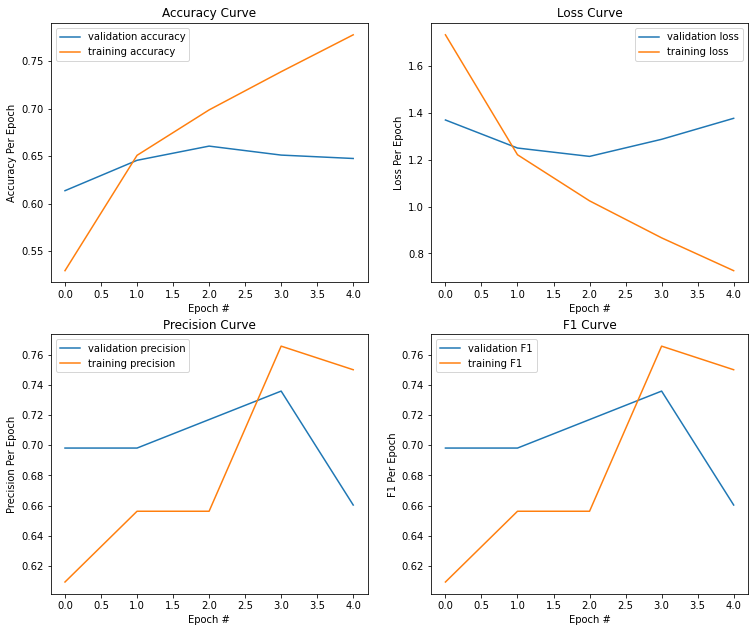

In [69]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure, axis = plt.subplots(2, 2)
figure.set_size_inches(12.5, 10.5, forward=True)
axis[0, 0].plot(valAcc, label='validation accuracy')
axis[0, 0].plot(trainAcc, label='training accuracy')
axis[0, 0].set_xlabel('Epoch #')
axis[0, 0].set_ylabel('Accuracy Per Epoch')
axis[0, 0].set_title('Accuracy Curve')
axis[0, 0].legend()
axis[0, 1].plot(valLoss, label='validation loss')
axis[0, 1].plot(trainLoss, label='training loss')
axis[0, 1].set_xlabel('Epoch #')
axis[0, 1].set_ylabel('Loss Per Epoch')
axis[0, 1].set_title('Loss Curve')
axis[0, 1].legend()
axis[1, 0].plot(valPrec, label='validation precision')
axis[1, 0].plot(trainPrec, label='training precision')
axis[1, 0].set_xlabel('Epoch #')
axis[1, 0].set_ylabel('Precision Per Epoch')
axis[1, 0].set_title('Precision Curve')
axis[1, 0].legend()
axis[1, 1].plot(valF1, label='validation F1')
axis[1, 1].plot(trainF1, label='training F1')
axis[1, 1].set_xlabel('Epoch #')
axis[1, 1].set_ylabel('F1 Per Epoch')
axis[1, 1].set_title('F1 Curve')
axis[1, 1].legend()

In [70]:
test_loss, test_acc, my_test_f1, my_test_prec = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} '
      f'| Test Acc: {test_acc*100:.2f}'
      f'| Test F1: {my_test_f1*100:.2f} | Test Prec: {my_test_prec*100:.2f}%')

Test Loss: 1.384 | Test Acc: 64.77| Test F1: 69.77 | Test Prec: 69.77%


**User Input**

In this section, we let ourself to put our own input and let the model predict the news' categories beyond the dataset. For consistencies, we will use news from Huffington Post and try to get its category predicted. Make sure that the first input is the headline and the second input is the short description of the article.

News can be obtained from [here](https://www.huffpost.com/).

In [71]:
import spacy
nlp = spacy.load('en')

def predict_category(model, head, desc):
    model.eval()
    head = head.lower()
    desc = desc.lower()
    tokenized_head = [tok.text for tok in nlp.tokenizer(head)]
    tokenized_desc = [tok.text for tok in nlp.tokenizer(desc)]
    indexed_head = [TEXT.vocab.stoi[t] for t in tokenized_head]
    indexed_desc = [TEXT.vocab.stoi[t] for t in tokenized_desc]
    tensor_head = torch.LongTensor(indexed_head).to(device)
    tensor_desc = torch.LongTensor(indexed_desc).to(device)
    tensor_head = tensor_head.unsqueeze(1)
    tensor_desc = tensor_desc.unsqueeze(1)
    prediction = model(tensor_head, tensor_desc)
    max_pred = prediction.argmax(dim=1)
    return max_pred.item()

News headline: Trump’s Art Of Distraction

News short description: The conversation surrounding Trump’s latest racist rants has provoked us to revisit author Toni Morrison’s 1975 keynote address at Portland State University on the true purpose of racism.

Correct category: Politics

In [72]:
pred = predict_category(model, "Trump’s Art Of Distraction", "The conversation surrounding Trump’s latest racist rants has provoked us to revisit author Toni Morrison’s 1975 keynote address at Portland State University on the true purpose of racism..")
print(f'Predicted category is: {pred} = {LABEL.vocab.itos[pred]}')

Predicted category is: 0 = POLITICS


News headline: Indiana Cop Apologizes After Accusing McDonald’s Worker Of Eating His Sandwich

News short description: The Marion County sheriff’s deputy forgot he had taken a bite out of his McChicken earlier that day, authorities said.

Correct category: U.S. News

In [73]:
pred = predict_category(model, "Indiana Cop Apologizes After Accusing McDonald’s Worker Of Eating His Sandwich", "The Marion County sheriff’s deputy forgot he had taken a bite out of his McChicken earlier that day, authorities said.")
print(f'Predicted category is: {pred} = {LABEL.vocab.itos[pred]}')

Predicted category is: 12 = BLACK VOICES


News headline: Kyle ‘Bugha’ Giersdorf, 16, Wins Fortnite World Cup And Takes Home $ 3 Million Prize

News short description: Fortnite has nearly 250 million registered players and raked in an estimated $2.4 billion last year.

Correct category: Sports

In [74]:
pred = predict_category(model, "Kyle ‘Bugha’ Giersdorf, 16, Wins Fortnite World Cup And Takes Home $ 3 Million Prize", "Fortnite has nearly 250 million registered players and raked in an estimated $2.4 billion last year.")
print(f'Predicted category is: {pred} = {LABEL.vocab.itos[pred]}')

Predicted category is: 11 = SPORTS


**References**

This notebook was created thanks to the two references below.
* http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
* https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb